In [4]:
## Imports
import os
import joblib
import scipy
import collections
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

import fa
import subspace
import data_loader as io

import warnings
warnings.filterwarnings('ignore')

In [5]:
## Global variables and useful functions

SUBJS = 'ABCDFIJWXYZ'
SAVEFIG = True
VERBOSE = False
TASK_NAMES = ['podcast','pursuit','rotations']
TASK_KEY = dict(zip(TASK_NAMES, ['C','S','R']))
TASK_CLR = dict(zip(TASK_NAMES, ['#F24B69','#24A5F5','#FFBA36']))
TASK_SHAPE = dict(zip(TASK_NAMES, ['s','o','^']))
TASK_PAIRS = ['CS','CR','RS']
TASK_PAIRS_CLR = dict(zip(TASK_PAIRS, ["#66c5cc","#f6cf71","#f89c74"]))
SUBJ_CLR = dict(zip(SUBJS, [plt.cm.rainbow(i/len(SUBJS)) for i in range(len(SUBJS))]))
AREA_CLR = {'HPC': 'purple', 'ACC': 'green'}
RUN_CV = True

def read_all_sessions(max_gap_dur_secs: float = 1.0,
                      bin_size: int = 200,
                      brain_areas_for_analysis: tuple[str]|list[str] = ('HPC', 'ACC'),
                      strict_brain_areas: bool = True,
                      event_mode: str = 'events',
                      filter_low_fr: bool = False,
                      get_subspace: bool = False):
    
    # The df is built on load_sessions.
    df = io.load_sessions()
    df['session_class'] = {}

    # Read session class and store in df.
    for task_name in ['pursuit', 'podcast', 'rotations']:
        session_infos = io.get_session_names(task_name,
                                             brain_areas=['HPC','ACC']) # If the session has recording from HPC or ACC, we read it.
        for session_info in session_infos:
            S = io.Session(session_info)
            try:
                S.get_spikes(binsize=bin_size, 
                             brain_areas_for_analysis=brain_areas_for_analysis, # We can choose which areas to read, HPC, ACC, or both
                             strict_brain_areas=strict_brain_areas) # If True, the session has to have all the regions specified in brain_areas_for_analysis.
            except ValueError as e:
                print(f'Skipping {S.session_key} due to error: {e}')
                continue

            if filter_low_fr:
                S.filter_low_firing_rate()

            S.get_events(mode=event_mode, max_gap_dur_secs=max_gap_dur_secs)
            S.get_spikes_mu_sd(verbose=VERBOSE)

            if get_subspace:
                if S.Y_norm.shape[0] > 500: 
                    # Only compute subspace if there are enough samples.
                    # Especially for 'gaps' mode, the number of samples can be very small for the pursuit task. 
                    S.find_subspace()
                else:
                    print(f'Skipping {S.session_key} due to missing Y_norm')
            df.loc[df.session_key==S.session_key, 'session_class'] = S

    return df

def get_single_task_df(df_all, task_name: str):

    if np.all(pd.isna(df_all.session_class)):
        print('Session class not read yet.')
        return

    print(f'Analyzing {task_name} task sessions...')
    df_single = df_all[(df_all.Task==task_name.capitalize()) & ~pd.isna(df_all.session_class)]
    j = []
    for i in range(len(df_single)):
        S = df_single.iloc[i]['session_class']
        if np.all(S.spikes_sd == 0):
            print(f'Skipping {S.session_key} due to zero spikes_sd')
        else:
            j.append(i)
    print(f'Found {len(df_single)} analyzable {task_name} sessions over {len(np.unique(df_single.Patient))} patients. Found spikes in {len(j)} sessions.')
    df_single = df_single.iloc[j]
    return df_single

def get_single_subj_df(df_all, patient_name: str, verbose=False):
    if len(patient_name) > 1:
        patient_name = patient_name[-1] # Only taking the last character
    if patient_name not in SUBJS:
        raise ValueError('Patient name not listed')

    df_single = df_all[(df_all.Patient.apply(lambda x: x[-1]) == patient_name) & ~pd.isna(df_all.session_class)]

    j = []
    for i in range(len(df_single)):
        S = df_single.iloc[i]['session_class']
        if np.all(S.spikes_sd == 0) and verbose:
            print(f'Skipping {S.session_key} due to zero spikes_sd')
        else:
            j.append(i)

    if len(df_single) == 0:
        if verbose:
            print(f'No recording for patient {patient_name}')
        return
    else:
        if verbose:
            print(f'Found {len(df_single)} analyzable sessions in patient {patient_name}. Found spikes in {len(j)} sessions.')
        return df_single
    
def get_paired_df(df_all):

    df_paired = []

    # make sure fields are valid.
    fields = ['Patient','Task','Datetime','session_file','session_class']
    if not all([f for f in fields if f in df_all.keys()]):
        raise ValueError('Fields should be in {list(df_all.keys())}')

    # First find df_single for each subj
    for subj in SUBJS:
        df_single = df_all[(df_all.Patient.apply(lambda x: x[-1]) == subj) & ~pd.isna(df_all.session_class)]

        for i in range(len(df_single)):
            for j in range(i, len(df_single)):
                task_1 = df_single.iloc[i][fields]
                task_2 = df_single.iloc[j][fields]
                if np.abs(task_1.Datetime-task_2.Datetime) > pd.Timedelta(hours=30):
                    continue
                if task_1.Task == task_2.Task:
                    continue

                # Return 'CS', 'RS', or 'CR' exclusively.
                task_pair = ''.join(sorted(list(map(lambda x: TASK_KEY[x.lower()], [task_1.Task,task_2.Task]))))

                pair = {'subj': subj, 
                        'task_pair': task_pair,
                        'task_1': task_1.session_class,
                        'task_2': task_2.session_class}
                
                df_paired.append(pair)

    df_paired = pd.DataFrame(df_paired)
    return df_paired

def shuffle_data(arr1, arr2, seed: int = None):
    """
    arr1 (M,N) and arr2 (M,K) are arrays to be concatenated to the first axis.
    """

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    a1, a2 = arr1.copy(), arr2.copy()
    A = np.concatenate((a1,a2), axis=0)
    inds = rng.permutation(A.shape[0])
    A1 = A[inds[:A.shape[0]//2]]
    A2 = A[inds[A.shape[0]//2:]]
    return (A1, A2)

def compute_distances(row, fa_field="FA", ix_field=None, niters_rand=1000, niters_shuf=30, plot_example=False):
    """Compute true, shuffled, and random geodesic distances for one task pair."""

    if not hasattr(row.task_1, fa_field) or not hasattr(row.task_2, fa_field):
        return {
            "true_dists": np.nan,
            "shuf_ang_means": np.nan,
            "rand_ang_means": np.nan,
            "shuf_dist_means": np.nan,
            "shuf_dist_stds": np.nan,
            "rand_dist_means": np.nan,
            "rand_dist_stds": np.nan,
            "is_shared": np.nan,
            "clrs": np.nan,
        }
    task1, task2 = row.task_1, row.task_2
    sub1, sub2 = getattr(task1, fa_field).subspace, getattr(task2, fa_field).subspace

    # true + random angles
    ang = subspace.principal_angles(sub1.T, sub2.T)
    rand_angles = subspace.rand_principal_angles(sub1.T, sub2.T, niters=niters_rand)

    # shuffled angles
    shuf_angles = []
    for seed in range(niters_shuf):
        y1 = task1.Y_norm if ix_field is None else task1.Y_norm[:, getattr(task1, ix_field)]
        y2 = task2.Y_norm if ix_field is None else task2.Y_norm[:, getattr(task2, ix_field)]
        yshuf1, yshuf2 = shuffle_data(y1, y2, seed=seed)
        fashuf1 = io.FactorAnalysisResult(fa.fa_fit(yshuf1, verbose=False))
        fashuf2 = io.FactorAnalysisResult(fa.fa_fit(yshuf2, verbose=False))
        shuf_angles.append(
            subspace.principal_angles(fashuf1.subspace.T, fashuf2.subspace.T)
        )

    # truncate to shortest angle length
    min_len = min(min(map(len, shuf_angles)), len(ang))
    shuf_angles = [arr[:min_len] for arr in shuf_angles]

    # distances
    shuf_dist = np.linalg.norm(shuf_angles, axis=1)
    rand_dist = np.linalg.norm(rand_angles, axis=1)
    true_dist = np.linalg.norm(ang[:min_len])

    if np.sum(true_dist > rand_dist) / len(rand_dist) < 0.001:
        is_shared = True
    else:
        is_shared = False

    # Compute normalized angles
    
    low_bound = np.mean(shuf_angles, axis=0)
    up_bound = np.mean(rand_angles, axis=0)
    normalized_ang = (ang[:min_len]-low_bound[:min_len]) / (up_bound[:min_len]-low_bound[:min_len])

    if plot_example:
        plt.figure(figsize=(3,4))
        plt.hist(rand_dist, bins=30, color='k', density=True)
        plt.hist(shuf_dist, bins=30, color='b', density=True)
        plt.axvline(true_dist)
        plt.xlabel('Geodesic distance (deg)')
        plt.xticks(np.linspace(0,180,5))
        plt.title(f'{true_dist:.2f}, rand {np.mean(rand_dist):.2f}±{np.std(rand_dist):.2f}', fontsize=10)
        save_plot_dir = os.path.join('plots', 'principal_angles')
        if not os.path.exists(save_plot_dir):
            os.makedirs(save_plot_dir)
        if SAVEFIG:
            for ext in ['png','svg']:
                plt.savefig(os.path.join(save_plot_dir, f'rand_dist_example.' + ext))
        plt.show()

    return {
        "true_dists": true_dist,
        "shuf_ang_means": np.mean(shuf_angles, axis=0),
        "rand_ang_means": np.mean(rand_angles, axis=0),
        "shuf_dist_means": np.mean(shuf_dist),
        "shuf_dist_stds": np.std(shuf_dist),
        "rand_dist_means": np.mean(rand_dist),
        "rand_dist_stds": np.std(rand_dist),
        "clrs": TASK_PAIRS_CLR[row.task_pair],
        "normalized_ang": normalized_ang,
        "is_shared": is_shared,
    }

def add_distance_metrics(df_pairs, mode="both", niters_rand=1000, niters_shuf=30):
    """
    mode: "both" -> use FA (all units),
          "hpc"  -> use FA_hpc, hpc_ix,
          "acc"  -> use FA_acc, acc_ix
    """
    mapping = {
        "both": ("FA", None),
        "hpc":  ("FA_hpc", "hpc_ix"),
        "acc":  ("FA_acc", "acc_ix"),
    }
    fa_field, ix_field = mapping[mode]

    results = df_pairs.apply(
        compute_distances,
        axis=1,
        fa_field=fa_field,
        ix_field=ix_field,
        niters_rand=niters_rand,
        niters_shuf=niters_shuf,
    )

    return pd.concat([df_pairs.reset_index(drop=True), results.apply(pd.Series)], axis=1)

def plot_geodesic_distance(df, region, savefig=False):

    plt.figure(figsize=(9,4))
    for j in range(3):
        plt.subplot(1,3,j+1)
        dd = df[df.task_pair == TASK_PAIRS[j]]

        compare_shuf = scipy.stats.wilcoxon(dd.true_dists, dd.shuf_dist_means, alternative='greater')
        compare_rand = scipy.stats.wilcoxon(dd.true_dists, dd.rand_dist_means, alternative='less')
        pval_shuf, pval_rand = compare_shuf[1], compare_rand[1]

        for i in range(len(dd)):
            plt.scatter([0,1,2],[
                dd.iloc[i]['shuf_dist_means'], 
                dd.iloc[i]['true_dists'], 
                dd.iloc[i]['rand_dist_means']], ec=dd.iloc[i]['clrs'],s=50, fc='none')
            plt.plot([0,1,2],[
                dd.iloc[i]['shuf_dist_means'], 
                dd.iloc[i]['true_dists'], 
                dd.iloc[i]['rand_dist_means']],c=dd.iloc[i]['clrs'])
            plt.errorbar(0, dd.iloc[i]['shuf_dist_means'], yerr=dd.iloc[i]['shuf_dist_stds'], c=dd.iloc[i]['clrs'])
            plt.errorbar(2, dd.iloc[i]['rand_dist_means'], yerr=dd.iloc[i]['rand_dist_stds'], c=dd.iloc[i]['clrs'], capsize=0.2)
        plt.xticks([0,1,2], ['Shuffle','Data','Random'])
        plt.xlim([-0.5,2.5])
        plt.yticks([0,90,180,270])
        plt.ylabel('Subspace distance (deg)')
        plt.title(f'{TASK_PAIRS[j]}\nshuf {pval_shuf:.2e}\nrand {pval_rand:.2e}', fontsize=10)
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9)
    save_plot_dir = os.path.join('plots', 'principal_angles')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if savefig:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'subspace_distance_sep_{region}.' + ext))
    plt.show()

def calc_var_exp(row, n_in_low_group=None):
    t1, t2 = row.task_1, row.task_2
    if not hasattr(t1, 'FA') or not hasattr(t2, 'FA'):
        return {
        'vA_max': np.nan, 
        'vA_low': np.nan, 
        'vA_high': np.nan, 
        'vB_max': np.nan, 
        'vB_low': np.nan, 
        'vB_high': np.nan
    }
    A = t1.FA.subspace
    B = t2.FA.subspace

    # Ua, Ub is the rotation matrix that best aligns subspace A and B
    angles, Ua, Ub = subspace.principal_angles(A.T, B.T, return_vectors=True)
    Ub = Ub.T

    varA   = np.var(t1.Y_norm @ A.T, axis=0)
    varA_p = np.var(t1.Y_norm @ A.T @ Ua, axis=0)
    varB   = np.var(t2.Y_norm @ B.T, axis=0)
    varB_p = np.var(t2.Y_norm @ B.T @ Ub, axis=0)

    n_in_low_group = n_in_low_group or len(angles) // 2

    # Trim arrays if needed
    total = 2 * n_in_low_group
    if total < len(angles):
        varA_p = varA_p[:total]
        varB_p = varB_p[:total]
        assert len(varA_p) == total

    return {
        'vA_max': np.sum(varA[:n_in_low_group]) / np.sum(varA), 
        'vA_low': np.sum(varA_p[:n_in_low_group]) / np.sum(varA), 
        'vA_high': np.sum(varA_p[n_in_low_group:]) / np.sum(varA), 
        'vB_max': np.sum(varB[:n_in_low_group]) / np.sum(varB), 
        'vB_low': np.sum(varB_p[:n_in_low_group]) / np.sum(varB), 
        'vB_high': np.sum(varB_p[n_in_low_group:]) / np.sum(varB)
    }

In [ ]:
## Read all sessions
df_singles = read_all_sessions(max_gap_dur_secs=1, bin_size=50, 
                               strict_brain_areas=False, event_mode='events', 
                               get_subspace=True, filter_low_fr=False)

df_pairs = get_paired_df(df_singles)

plt.figure(figsize=9,3)

for k, pair_name in enumerate(TASK_PAIRS):
    plt.subplot(1,3,k+1)

In [6]:
## Figure 2. Panel F, G, and H.

plt.figure(figsize=(len(TASK_PAIRS)*4,4))
for area in ['HPC','ACC']:

    df_singles = read_all_sessions(max_gap_dur_secs=1, bin_size=50, strict_brain_areas=False,
                                   brain_areas_for_analysis=[area])
    
    df_pairs = get_paired_df(df_singles)
    for k, pair_name in enumerate(TASK_PAIRS):
        plt.subplot(1,len(TASK_PAIRS),k+1)
        pairs = df_pairs[df_pairs.task_pair == pair_name]
        for i in range(len(pairs)):
            s1, s2 = pairs.iloc[i].task_1, pairs.iloc[i].task_2
            plt.scatter(s1.spikes_mu, s2.spikes_mu, s=25, ec=AREA_CLR[area], fc='none', lw=1, marker='o')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(f'{s1.task} FR')
        plt.ylabel(f'{s2.task} FR')
        plt.title(pair_name)
        plt.plot([0.5,50],[0.5,50], ls='--', c='k')
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.2,wspace=0.5)

save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'firing_rates_show-areas.' + ext))
plt.show()

Found 13 sessions for task pursuit with brain areas ['HPC', 'ACC'].
Session W-S2: Keeping 32 of 64 channels matching brain areas ['HPC']
Session W-S2: 100 events, "events" mode. Keep 20190 out of 21720 bins.
Session W-S1: Keeping 32 of 64 channels matching brain areas ['HPC']
Session W-S1: 100 events, "events" mode. Keep 21580 out of 21928 bins.
Session X-S2: Keeping 32 of 56 channels matching brain areas ['HPC']
Session X-S2: 100 events, "events" mode. Keep 34720 out of 55384 bins.
Session X-S1: Keeping 32 of 56 channels matching brain areas ['HPC']
Session X-S1: 100 events, "events" mode. Keep 27227 out of 27904 bins.
Session Y-S1: Keeping 16 of 16 channels matching brain areas ['HPC']
Session Y-S1: 149 events, "events" mode. Keep 57035 out of 57081 bins.
Session Z-S1: Keeping 16 of 24 channels matching brain areas ['HPC']
Session Z-S1: 100 events, "events" mode. Keep 29968 out of 35652 bins.
Session A-S1: Keeping 32 of 40 channels matching brain areas ['HPC']
Session A-S1: 100 event

KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

In [7]:
## Read all sessions
df_singles = read_all_sessions(max_gap_dur_secs=1, bin_size=50, 
                               strict_brain_areas=False, event_mode='events', 
                               get_subspace=True, filter_low_fr=False)

Found 13 sessions for task pursuit with brain areas ['HPC', 'ACC'].
Session W-S2: Keeping 48 of 64 channels matching brain areas ['ACC', 'HPC']
Session W-S2: 100 events, "events" mode. Keep 20190 out of 21720 bins.
Session W-S1: Keeping 48 of 64 channels matching brain areas ['ACC', 'HPC']
Session W-S1: 100 events, "events" mode. Keep 21580 out of 21928 bins.
Session X-S2: Keeping 56 of 56 channels matching brain areas ['ACC', 'HPC']
Session X-S2: 100 events, "events" mode. Keep 34720 out of 55384 bins.
Session X-S1: Keeping 56 of 56 channels matching brain areas ['ACC', 'HPC']
Session X-S1: 100 events, "events" mode. Keep 27227 out of 27904 bins.
Session Y-S1: Keeping 16 of 16 channels matching brain areas ['HPC']
Session Y-S1: 149 events, "events" mode. Keep 57035 out of 57081 bins.
Session Z-S1: Keeping 16 of 24 channels matching brain areas ['HPC']
Session Z-S1: 100 events, "events" mode. Keep 29968 out of 35652 bins.
Session A-S1: Keeping 40 of 40 channels matching brain areas ['A

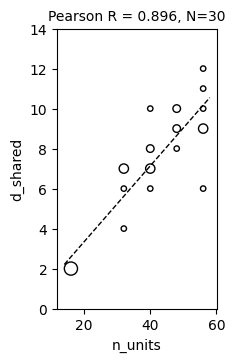

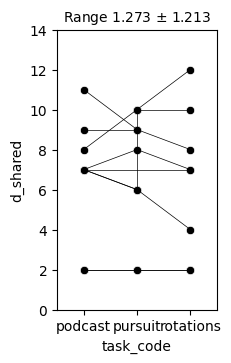

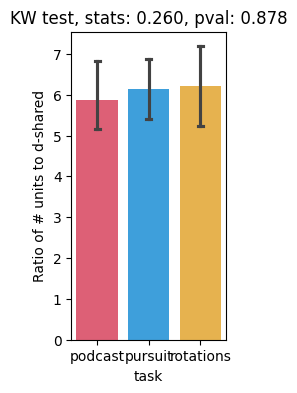

In [8]:
## Figure 3. Panel C, D, and E.

n_units = df_singles['session_class'].apply(lambda s: s.FA.n_components)
d_shared = df_singles['session_class'].apply(lambda s: s.FA.d_shared)

res = scipy.stats.linregress(n_units, d_shared)
pearsonr = res.rvalue
n_sample = len(n_units)
x_range = np.array([np.min(n_units)-2, np.max(n_units)+2])

plt.figure(figsize=(2,4))
for pair, value in collections.Counter(list(zip(n_units, d_shared))).items():
    plt.scatter(*pair, s=value*15, ec='k',fc='none', lw=1)

plt.plot(x_range, x_range*res.slope+res.intercept,ls='--', c='k', lw=1)
plt.ylim([0,14])
plt.xlabel('n_units')
plt.ylabel('d_shared')
plt.title(f'Pearson R = {pearsonr:.3f}, N={n_sample}', fontsize=10)
plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.8)
save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'd_shared_n_units.' + ext))
plt.show()

code = dict(zip(TASK_NAMES, [0,1,2]))
dfs = df_singles[['Patient','Task','session_class']]
dfs['d_shared'] = df_singles['session_class'].apply(lambda s: s.FA.d_shared)
dfs['task_code'] = dfs['Task'].str.lower().apply(lambda x: code[x])

range_array = []
for j in range(len(SUBJS)):
    dd = get_single_subj_df(dfs, SUBJS[j])
    range_array.append(dd.d_shared.max() - dd.d_shared.min())


fig,ax = plt.subplots(1,1,figsize=(2,4))
sns.scatterplot(data=dfs, x='task_code', y='d_shared',ax=ax, color='k')
for j in range(len(SUBJS)):
    dd = get_single_subj_df(dfs, SUBJS[j])
    
    for i in range(len(dd) - 1):
        xs = (dd.iloc[i]['task_code'], dd.iloc[i+1]['task_code'])
        ys = (dd.iloc[i]['d_shared'], dd.iloc[i+1]['d_shared'])
        ax.plot(xs, ys, c='k', ls='-', lw=0.5)
plt.xticks([0,1,2],TASK_NAMES)
plt.xlim([-0.5,2.5])
plt.title(f'Range {np.mean(range_array):.3f} $\pm$ {np.std(range_array):.3f}', fontsize=10)
plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.8)
plt.ylim([0,14])
save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'd_shared_per_session.' + ext))
plt.show()

n_units = df_singles['session_class'].apply(lambda s: s.FA.n_components)
d_shared = df_singles['session_class'].apply(lambda s: s.FA.d_shared)
df = pd.DataFrame({'ratio': n_units/d_shared, 'task': df_singles.Task.str.lower()})
res = scipy.stats.kruskal(
    df[df.task=='podcast'].ratio,
    df[df.task=='pursuit'].ratio,
    df[df.task=='rotations'].ratio)

fig,ax = plt.subplots(1,1,figsize=(2,4))
sns.barplot(data=df, x='task',y='ratio', capsize=0.1, ax=ax, palette=TASK_CLR)
plt.ylabel('Ratio of # units to d-shared')
plt.title(f'KW test, stats: {res.statistic:.3f}, pval: {res.pvalue:.3f}')

save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'd_shared_ratio_per_task.' + ext))
plt.show()


Found 13 sessions for task pursuit with brain areas ['HPC', 'ACC'].
Session W-S2: Keeping 48 of 64 channels matching brain areas ['ACC', 'HPC']
Session W-S2: 100 events, "events" mode. Keep 20190 out of 21720 bins.
Session W-S1: Keeping 48 of 64 channels matching brain areas ['ACC', 'HPC']
Session W-S1: 100 events, "events" mode. Keep 21580 out of 21928 bins.
Session X-S2: Keeping 56 of 56 channels matching brain areas ['ACC', 'HPC']
Session X-S2: 100 events, "events" mode. Keep 34720 out of 55384 bins.
Session X-S1: Keeping 56 of 56 channels matching brain areas ['ACC', 'HPC']
Session X-S1: 100 events, "events" mode. Keep 27227 out of 27904 bins.
Session Y-S1: Keeping 16 of 16 channels matching brain areas ['HPC']
Session Y-S1: 149 events, "events" mode. Keep 57035 out of 57081 bins.
Session Z-S1: Keeping 16 of 24 channels matching brain areas ['HPC']
Session Z-S1: 100 events, "events" mode. Keep 29968 out of 35652 bins.
Session A-S1: Keeping 40 of 40 channels matching brain areas ['A

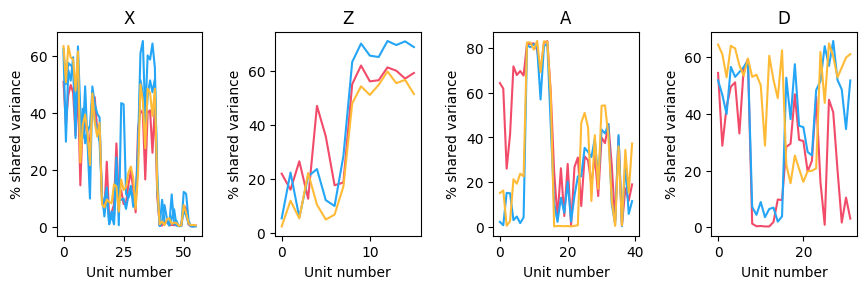

In [9]:
## Figure 3. Panel F.

df_singles = read_all_sessions(max_gap_dur_secs=1, bin_size=50, 
                               strict_brain_areas=False, event_mode='events', 
                               get_subspace=True, filter_low_fr=False)
subj_complete_all_tasks = 'XZAD' 

# There are four subjects that finished all three tasks.
# The example patient in the paper is X.
plt.figure(figsize=(10,3))
for i in range(len(subj_complete_all_tasks)):
    df_three_task = df_singles[df_singles.Patient.apply(lambda x: x[-1]) == subj_complete_all_tasks[i]]
    plt.subplot(1,len(subj_complete_all_tasks),i+1)
    for j in range(len(df_three_task)):
        s = df_three_task.iloc[j].session_class
        s.find_subspace()
        
        # Scatter plot 
        # plt.scatter(range(len(s.channels)), s.FA.shared_var_per_unit*100, c=TASK_CLR[s.task], s=5)
        
        # Line plot
        plt.plot(s.FA.shared_var_per_unit*100,  c=TASK_CLR[s.task])
    plt.xlabel('Unit number')
    plt.ylabel('% shared variance')
    plt.title(subj_complete_all_tasks[i])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.2,wspace=0.5)

save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'shared_var_per_unit.' + ext))
plt.show()

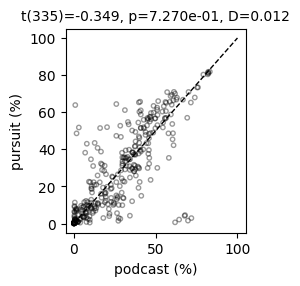

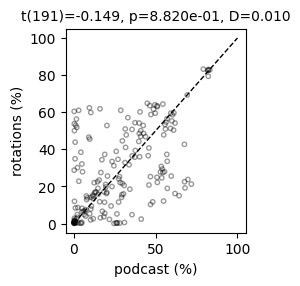

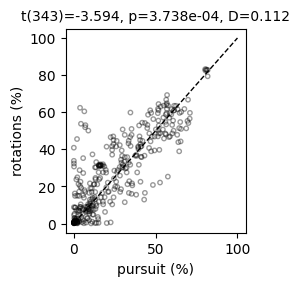

In [10]:
## Figure 3. Panel G, H, and I.
df_pairs = get_paired_df(df_singles)

for j in range(len(TASK_PAIRS)):
    df_pair = df_pairs[df_pairs.task_pair == TASK_PAIRS[j]]

    plt.figure(figsize=(3,3))
    xs, ys = [], []
    for i in range(len(df_pair)):
        df = df_pair.iloc[i]
        x = df.task_1.FA.shared_var_per_unit
        y = df.task_2.FA.shared_var_per_unit
        plt.scatter(x*100, y*100, ec='k', fc='none', s=10, alpha=0.4)
        xs.append(x); ys.append(y)

    xs = np.hstack(xs); ys = np.hstack(ys)
    res = pg.ttest(xs,ys, paired=True)
    stats = res.iloc[0]['T']
    pval = res.iloc[0]['p-val']
    dof = res.iloc[0]['dof']
    cohen = res.iloc[0]['cohen-d']

    plt.xlabel(df.task_1.task + ' (%)')
    plt.ylabel(df.task_2.task + ' (%)')
    # plt.xticks(np.linspace(0,100,6)); plt.yticks(np.linspace(0,100,6))
    plt.plot([0.1,100],[0.1,100],ls='--',c='k',lw=1)
    plt.title(f't({dof})={stats:.3f}, p={pval:.3e}, D={cohen:.3f}', fontsize=10)
    plt.subplots_adjust(left=0.2,right=0.8, bottom=0.2)
    save_plot_dir = os.path.join('plots', 'general_plots')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if SAVEFIG:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'shared_var_per_unit_paired_{j+1}.' + ext))
    plt.show()

Analyzing podcast task sessions...
Found 7 analyzable podcast sessions over 7 patients. Found spikes in 7 sessions.
Analyzing pursuit task sessions...
Found 11 analyzable pursuit sessions over 8 patients. Found spikes in 11 sessions.
Analyzing rotations task sessions...
Found 6 analyzable rotations sessions over 6 patients. Found spikes in 6 sessions.


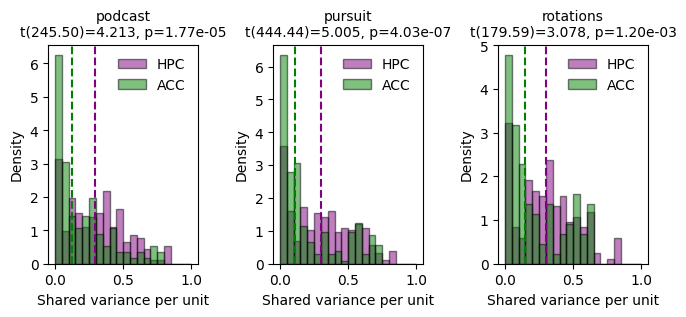

In [11]:
## Figure 4. Panel A, B, and C.
plt.figure(figsize=(8,3))
for j in range(len(TASK_NAMES)):
    plt.subplot(1,3,j+1)
    dfs = get_single_task_df(df_singles[(df_singles['Patient']!='YEY')&(df_singles['Patient']!='YEZ')], TASK_NAMES[j])
    hpc, acc = [], []
    for i in range(len(dfs)):
        s = dfs.iloc[i].session_class
        hpc.extend(s.FA.shared_var_per_unit[s.hpc_ix])
        acc.extend(s.FA.shared_var_per_unit[s.acc_ix])

    res = pg.ttest(hpc,acc, paired=False, alternative='greater')
    stats = res.iloc[0]['T']
    pval = res.iloc[0]['p-val']
    dof = res.iloc[0]['dof']

    plt.hist(hpc, bins=np.linspace(0,1,21), color=AREA_CLR['HPC'], alpha=0.5, edgecolor='k', density=True, label='HPC')
    plt.hist(acc, bins=np.linspace(0,1,21), color=AREA_CLR['ACC'], alpha=0.5, edgecolor='k', density=True, label='ACC')
    plt.axvline(np.median(hpc), ls='--',c=AREA_CLR['HPC'])
    plt.axvline(np.median(acc), ls='--',c=AREA_CLR['ACC'])
    plt.title(f'{TASK_NAMES[j]}\nt({dof:.2f})={stats:.3f}, p={pval:.2e}', fontdict={'size': 10})
    plt.xlabel('Shared variance per unit')
    plt.ylabel('Density')
    plt.legend(frameon=False)
plt.subplots_adjust(wspace=0.5,left=0.15,right=0.9,bottom=0.15)
save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'shared_var_per_unit_per_task.' + ext))
plt.show()

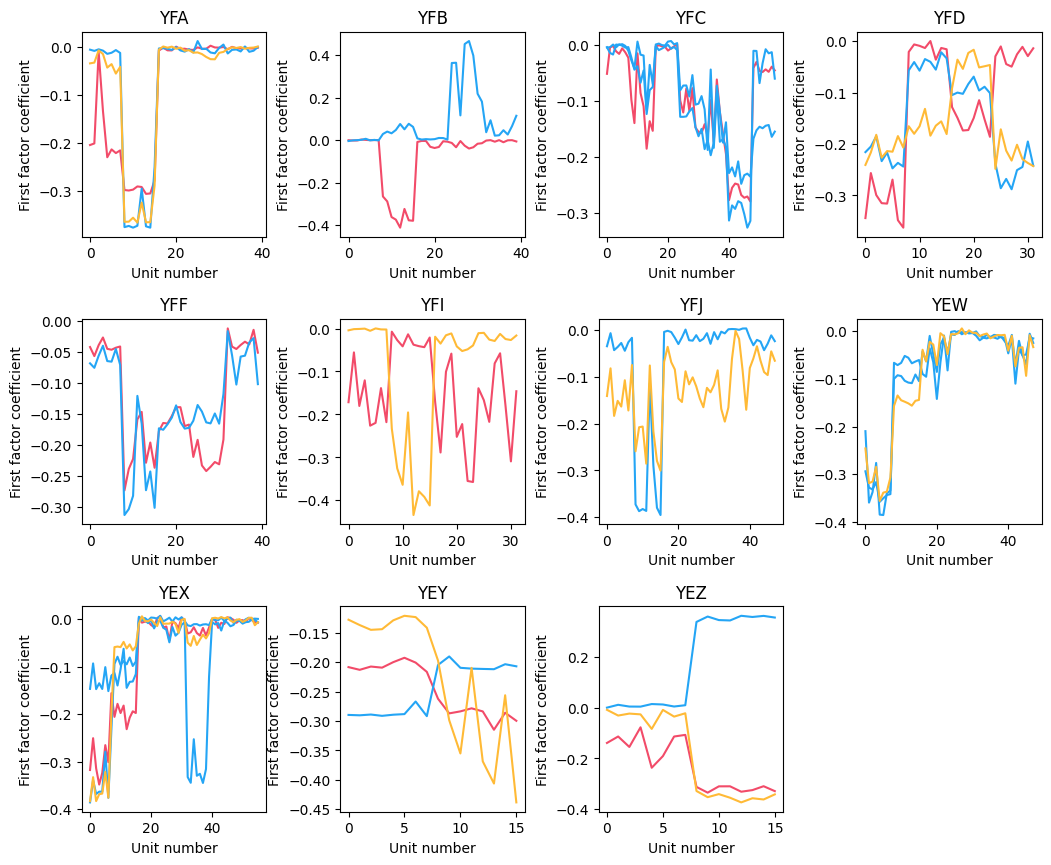

In [12]:
## Figure 5. Panel A.
# We are showing the result patient X, excluding one of repeated session from Pursuit (blue).
plt.figure(figsize=(12,10))
for j in range(len(SUBJS)):
    df = get_single_subj_df(df_singles, SUBJS[j])
    
    plt.subplot(3,4,j+1)
    for i in range(len(df)):
        s = df.iloc[i].session_class
        plt.plot(s.FA.subspace[0], c=TASK_CLR[s.task])
    plt.title(s.subj)
    plt.ylabel('First factor coefficient')
    plt.xlabel('Unit number')
plt.subplots_adjust(hspace=0.4,wspace=0.4, bottom=0.1, left=0.1, right=0.9)
save_plot_dir = os.path.join('plots', 'general_plots')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'first_factor_coeff.' + ext))
plt.show()



Analyzing podcast task sessions...
Found 7 analyzable podcast sessions over 7 patients. Found spikes in 7 sessions.
Analyzing pursuit task sessions...
Found 11 analyzable pursuit sessions over 8 patients. Found spikes in 11 sessions.
Analyzing rotations task sessions...
Found 6 analyzable rotations sessions over 6 patients. Found spikes in 6 sessions.


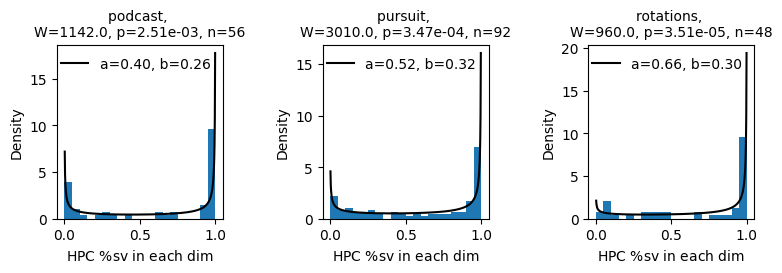

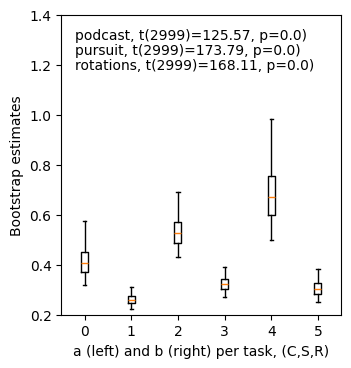

In [13]:
## Figure 4. Panel D, E, and F.

hpc_powers = collections.defaultdict(list)
for j in range(len(TASK_NAMES)):
    dfs = get_single_task_df(df_singles[(df_singles['Patient']!='YEY')&(df_singles['Patient']!='YEZ')],TASK_NAMES[j])
    for i in range(len(dfs)):
        s = dfs.iloc[i].session_class
        total_var_per_unit_per_dim = (s.FA.subspace)**2 # (d, N)
        hpc_powers[TASK_NAMES[j]].extend(total_var_per_unit_per_dim[:, s.hpc_ix].sum(axis=1))

plt.figure(figsize=(9,3))
for j in range(len(TASK_NAMES)):
    hpc_power = hpc_powers[TASK_NAMES[j]]
    hpc_stats = scipy.stats.wilcoxon(hpc_power, 0.5, alternative='greater')
    a0, b0, _, _ = scipy.stats.beta.fit(hpc_power, floc=0, fscale=1)

    x = np.linspace(0, 1, 500)
    pdf_values = scipy.stats.beta.pdf(x, a0, b0)
    plt.subplot(1,3,j+1)
    plt.hist(hpc_power, bins=np.linspace(0,1,21), density=True)
    plt.plot(x, pdf_values, c='k', label=f'a={a0:.2f}, b={b0:.2f}')
    plt.ylabel('Density')
    plt.xlabel('HPC $\%$sv in each dim')
    plt.title(f'{TASK_NAMES[j]}, \nW={hpc_stats.statistic}, p={hpc_stats.pvalue:.2e}, n={len(hpc_power)}',fontsize=10)
    plt.legend(frameon=False)
plt.subplots_adjust(wspace=0.6, bottom=0.3)
save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'hpc_sv_density.' + ext))
plt.show()

plt.figure(figsize=(4,5))
for  j in range(len(TASK_NAMES)):
    data = hpc_powers[TASK_NAMES[j]]
    n_boot = 3000
    rng = np.random.default_rng()
    n = len(data)
    a0, b0, _, _ = scipy.stats.beta.fit(data, floc=0, fscale=1)
    boots = np.empty((n_boot, 2))
    for i in range(n_boot):
        resamp = rng.choice(data, size=n, replace=True)
        ai, bi, _, _ = scipy.stats.beta.fit(resamp, floc=0, fscale=1)
        boots[i, :] = (ai, bi)

    beta_stats = pg.ttest(boots[:,0], boots[:,1], paired=True, alternative='greater')
    pval = beta_stats['p-val'].iloc[0]
    tval = beta_stats['T'].iloc[0]
    dof = beta_stats['dof'].iloc[0]
    plt.boxplot(boots, whis=(2.5,97.5), showfliers=False, positions=[j*2, j*2+1])
    plt.text(-0.2, 1.3-j*0.06, f'{TASK_NAMES[j]}, t({dof})={tval:.2f}, p={pval})', fontsize=10)
plt.ylim([0.2,1.4])
plt.ylabel('Bootstrap estimates')
plt.xlabel('a (left) and b (right) per task, (C,S,R)')
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.8)
save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'hpc_sv_betas.' + ext))
plt.show()

In [ ]:
## Figure 4. Panel G, H, and I.

if RUN_CV:
    dfs = df_singles[(df_singles.Patient!='YEY')&(df_singles.Patient!='YEZ')]
    hpc_diffs, acc_diffs = [], []
    for j in range(len(TASK_NAMES)):
        df = get_single_task_df(dfs, TASK_NAMES[j])

        hpc_svpu, acc_svpu, hpc_svpu_add, acc_svpu_add = [], [] ,[] ,[]
        hpc_diff, acc_diff = [], []

        for i in range(len(df)):
            print(f'{i} out of {len(df)} sessions in {TASK_NAMES[j]}')
            s = df.iloc[i].session_class
            Y = s.Y_norm

            # Fit FA for each region and both regions
            FA_hpc = io.FactorAnalysisResult(fa.fa_fit(
                Y[:, s.hpc_ix], cv_components=np.arange(Y[:, s.hpc_ix].shape[1]), max_iter=int(1e5)))
            FA_acc = io.FactorAnalysisResult(fa.fa_fit(
                Y[:, s.acc_ix], cv_components=np.arange(Y[:, s.acc_ix].shape[1]), max_iter=int(1e5)))
            FA_all = io.FactorAnalysisResult(fa.fa_fit(
                Y, cv_components=np.arange(Y.shape[1]), max_iter=int(1e5)))

            # Store shared var per unit
            hpc_svpu.extend(FA_hpc.shared_var_per_unit) # HPC's sv per unit (svpu) when fitting HPC only
            acc_svpu.extend(FA_acc.shared_var_per_unit) # ACC's svpu when fitting ACC only
            hpc_svpu_add.extend(FA_all.shared_var_per_unit[s.hpc_ix]) # HPC's svpu when fitting both regions
            acc_svpu_add.extend(FA_all.shared_var_per_unit[s.acc_ix]) # ACC's svpu when fitting both regions

            # Also store the difference
            hpc_diff.extend(FA_all.shared_var_per_unit[s.hpc_ix] - FA_hpc.shared_var_per_unit)
            acc_diff.extend(FA_all.shared_var_per_unit[s.acc_ix] - FA_acc.shared_var_per_unit)

        hpc_diffs.extend(hpc_diff)
        acc_diffs.extend(acc_diff)
        
        plt.figure(figsize=(4,4))
        plt.scatter(hpc_svpu, hpc_svpu_add, s=10, ec=AREA_CLR['HPC'], fc='none')
        plt.scatter(acc_svpu, acc_svpu_add, s=10, ec=AREA_CLR['ACC'], fc='none')
        plt.xlabel('sv per unit, fitting single region')
        plt.ylabel('sv per unit, fitting both regions')
        plt.plot([1e-2,1],[1e-2,1], c='k', ls='--', alpha=0.4)
        plt.title(f'{TASK_NAMES[j]}, thres=CV')
        # plt.xscale('log')
        # plt.yscale('log')
        plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)

        save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
        if not os.path.exists(save_plot_dir):
            os.makedirs(save_plot_dir)
        if SAVEFIG:
            for ext in ['png','svg']:
                plt.savefig(os.path.join(save_plot_dir, f'{TASK_NAMES[j]}_cv_1e5.' + ext))
        plt.show()

        stats, pval = scipy.stats.ttest_1samp(acc_diff, 0, alternative='greater')
        acc_info = f'ACC: t({len(acc_diff)-1})={stats:.3f}, p={pval:.2e}'
        stats, pval = scipy.stats.ttest_1samp(hpc_diff, 0, alternative='greater')
        hpc_info = f'HPC: t({len(hpc_diff)-1})={stats:.3f}, p={pval:.2e}'
        stats, pval = scipy.stats.ttest_ind(acc_diff, hpc_diff, alternative='greater')
        diff_info = f'∆: t({len(hpc_diff)+len(acc_diff)-2})={stats:.3f}, p={pval:.2e}'
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        sns.kdeplot(hpc_diff, ax=ax,color=AREA_CLR['HPC'])
        sns.kdeplot(acc_diff, ax=ax,color=AREA_CLR['ACC'])
        ax.set_xlim([-0.3,0.3])

        ax.set_title(f'{hpc_info}\n{acc_info}\n{diff_info}', fontsize=10)
        ax.set_xlabel('∆ shared var')
        ax.set_ylabel('Density')
        plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.2)

        save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
        if not os.path.exists(save_plot_dir):
            os.makedirs(save_plot_dir)
        if SAVEFIG:
            for ext in ['png','svg']:
                plt.savefig(os.path.join(save_plot_dir, f'{TASK_NAMES[j]}_diff_cv_1e5.' + ext))
        plt.show()

    stats, pval = scipy.stats.ttest_1samp(acc_diffs, 0, alternative='greater')
    acc_info = f'ACC: t({len(acc_diffs)-1})={stats:.3f}, p={pval:.2e}'
    stats, pval = scipy.stats.ttest_1samp(hpc_diffs, 0, alternative='greater')
    hpc_info = f'HPC: t({len(hpc_diffs)-1})={stats:.3f}, p={pval:.2e}'
    stats, pval = scipy.stats.ttest_ind(acc_diffs, hpc_diffs, alternative='greater')
    diff_info = f'∆: t({len(hpc_diffs)+len(acc_diffs)-2})={stats:.3f}, p={pval:.2e}'
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    sns.kdeplot(hpc_diffs, ax=ax,color=AREA_CLR['HPC'])
    sns.kdeplot(acc_diffs, ax=ax,color=AREA_CLR['ACC'])

    ax.set_xlim([-0.4,0.4])
    ax.set_title(f'{hpc_info}\n{acc_info}\n{diff_info}', fontsize=10)
    ax.set_xlabel('∆ shared var')
    ax.set_ylabel('Density')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.2)

    save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if SAVEFIG:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'diff_cv_ALL.' + ext))
    plt.show()

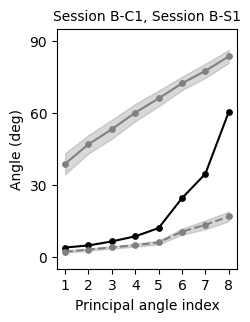

In [15]:
## Figure 5. Panel B. Use i=3 for the example in the paper. 
# for i in range(len(df_pairs)):
i=3
row = df_pairs.iloc[i]
task1, task2 = row.task_1, row.task_2
sub1, sub2 = task1.FA.subspace, task2.FA.subspace
ang = subspace.principal_angles(sub1.T, sub2.T)
rand_angles = subspace.rand_principal_angles(sub1.T, sub2.T, niters=100)

shuf_angles = []
for it in range(30):
    (yshuf1, yshuf2) = shuffle_data(task1.Y_norm, task2.Y_norm, seed=it)
    fashuf1 = io.FactorAnalysisResult(fa.fa_fit(yshuf1, verbose=False))
    fashuf2 = io.FactorAnalysisResult(fa.fa_fit(yshuf2, verbose=False))
    shuf_angles.append(subspace.principal_angles(fashuf1.subspace.T, fashuf2.subspace.T))

# Trim shuffle angles
min_len = min(list(map(len, shuf_angles)))
min_len = np.min((min_len, len(ang)))
shuf_angles = [elem[:min_len] for elem in shuf_angles]
assert np.min(list(map(len, shuf_angles)))==np.max(list(map(len, shuf_angles))), ValueError('Shuffle angles with different length, cannot average')

rand_mean = np.mean(rand_angles, axis=0)
rand_std = np.std(rand_angles, axis=0)
shuf_mean = np.mean(shuf_angles, axis=0)
shuf_std = np.std(shuf_angles, axis=0)

plt.figure(figsize=(3,4))
plt.scatter(range(len(ang)), ang, c='k', marker='o', s=15)
plt.plot(range(len(ang)), ang, c='k')
plt.scatter(range(len(ang)), rand_mean, c='gray', marker='o', s=15)
plt.plot(range(len(ang)), rand_mean, c='gray')
plt.fill_between(range(len(rand_mean)), rand_mean-rand_std, rand_mean+rand_std, color='gray', alpha=0.3)
plt.scatter(range(len(shuf_mean)), shuf_mean, c='gray', marker='o', s=15)
plt.plot(range(len(shuf_mean)), shuf_mean, c='gray', ls='--')
plt.fill_between(range(len(shuf_mean)), shuf_mean-shuf_std, shuf_mean+shuf_std, color='gray', alpha=0.3)
plt.title(f'{task1}, {task2}', fontsize=10)
plt.ylim([-5,95])
plt.yticks(np.linspace(0,90,4))
plt.xticks(np.arange(len(ang)), np.arange(len(ang))+1)
plt.xlabel('Principal angle index')
plt.ylabel('Angle (deg)')
plt.subplots_adjust(left=0.2,right=0.8, bottom=0.2, top=0.8)
save_plot_dir = os.path.join('plots', 'principal_angles')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'principal_ang_example_{i}.' + ext))
plt.show()

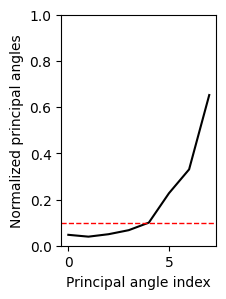

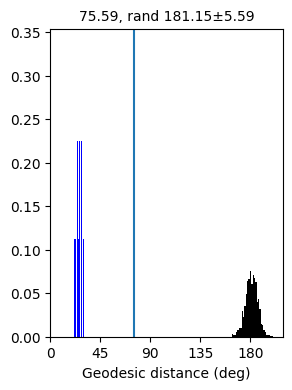

{'true_dists': np.float64(75.58535939020736),
 'shuf_ang_means': array([ 2.09270913,  2.9799616 ,  3.89039237,  4.79163765,  5.94261387,
        10.42600611, 13.2913613 , 16.76740828]),
 'rand_ang_means': array([38.77215257, 46.7570324 , 53.70313231, 60.12455423, 66.04355562,
        72.02271121, 77.68693922, 83.53492883]),
 'shuf_dist_means': np.float64(25.653516026750715),
 'shuf_dist_stds': np.float64(2.383329529815902),
 'rand_dist_means': np.float64(181.15495353925857),
 'rand_dist_stds': np.float64(5.588008946461344),
 'clrs': '#66c5cc',
 'normalized_ang': array([0.04721357, 0.03939886, 0.04975408, 0.06696336, 0.09965808,
        0.22657543, 0.32990318, 0.65174801]),
 'is_shared': True}

In [16]:
## Figure 5. Panel C. and Figure S5.
df_pairs_both = add_distance_metrics(df_pairs, mode="both", niters_rand=100, niters_shuf=30)
row = df_pairs_both.iloc[3]
res = compute_distances(row)

sub1, sub2 = row.task_1.FA.subspace, row.task_2.FA.subspace
rand_angles = subspace.rand_principal_angles(sub1.T, sub2.T, niters=1000)

plt.figure(figsize=(2,3))

plt.plot(res['normalized_ang'], c='k')
plt.xlabel('Principal angle index')
plt.ylabel('Normalized principal angles')
plt.axhline(0.1, c='r', ls='--', lw=1)
plt.ylim([0,1])
save_plot_dir = os.path.join('plots', 'principal_angles')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'normalized_principal_ang.' + ext))
plt.show()

compute_distances(row, plot_example=True)

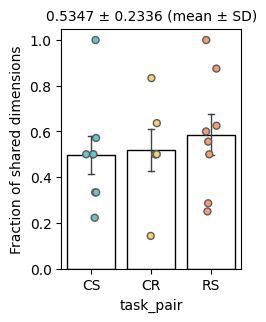

In [17]:
## Figure 5. Panel D.
res = []
for i in range(len(df_pairs_both)):
    ang = df_pairs_both.iloc[i]['normalized_ang']
    res.append((ang<0.1).sum()/len(ang))

df_pairs_both['frac_shared'] = res

fig, ax = plt.subplots(1,1,figsize=(3,4))
sns.stripplot(data=df_pairs_both, x='task_pair', y='frac_shared', palette=TASK_PAIRS_CLR, size=5, ax=ax,linewidth=1)
sns.barplot(data=df_pairs_both, x='task_pair', y='frac_shared', capsize=0.1, errorbar='se',ax=ax,facecolor='w',edgecolor='k',errwidth=1)
ax.set_ylabel('Fraction of shared dimensions')
ax.set_title(f'{df_pairs_both['frac_shared'].mean():.4f} ± {df_pairs_both['frac_shared'].std():.4f} (mean ± SD)', fontsize=10)
fig.subplots_adjust(left=0.2,right=0.8, bottom=0.2, top=0.8)
save_plot_dir = os.path.join('plots', 'principal_angles')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'fraction_of_dimensions_shared.' + ext))
plt.show()

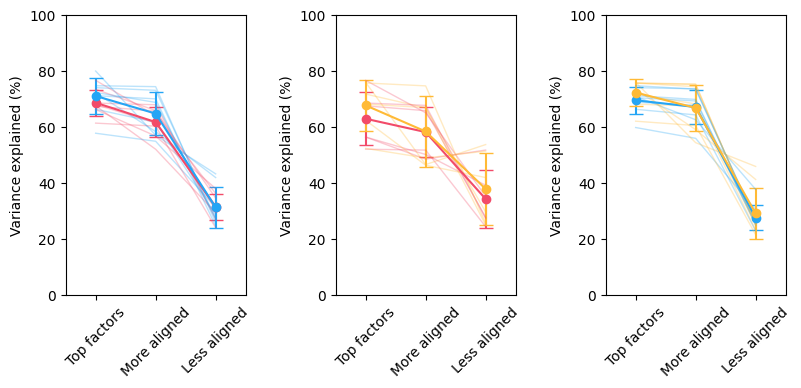

,Contrast,session,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,session,-,vA,vB,False,True,-0.334933,46.0,two-sided,7.391979e-01,NaN,NaN,0.301,-0.095102
1,alignment,-,high,low,False,True,-14.438556,30.0,two-sided,4.811533e-15,1.443460e-14,bonf,7.096e+11,-4.976108
2,alignment,-,high,max,False,True,-18.848712,30.0,two-sided,3.519647e-18,1.055894e-17,bonf,7.075e+14,-6.496025
3,alignment,-,low,max,False,True,-3.044363,30.0,two-sided,4.819286e-03,1.445786e-02,bonf,8.859,-1.049210
4,session * alignment,vA,high,low,False,True,-12.078853,14.0,two-sided,8.598738e-09,5.159243e-08,bonf,7.196e+05,-5.710003
5,session * alignment,vA,high,max,False,True,-15.956697,14.0,two-sided,2.239959e-10,1.343976e-09,bonf,2.011e+07,-7.543166
6,session * alignment,vA,low,max,False,True,-2.774431,14.0,two-sided,1.491178e-02,8.947069e-02,bonf,3.935,-1.311549
7,session * alignment,vB,high,low,False,True,-8.963949,14.0,two-sided,3.556383e-07,2.133830e-06,bonf,2.517e+04,-4.237503
8,session * alignment,vB,high,max,False,True,-11.475208,14.0,two-sided,1.656953e-08,9.941718e-08,bonf,3.969e+05,-5.424644
9,session * alignment,vB,low,max,False,True,-1.753662,14.0,two-sided,1.013440e-01,6.080639e-01,bonf,1.134,-0.829004


In [35]:
## Figure 6. Panel B.

df_pairs = get_paired_df(df_singles)
plt.figure(figsize=(9,4))
for j in range(3):
    plt.subplot(1,3,j+1)
    df_pair = df_pairs[df_pairs.task_pair == TASK_PAIRS[j]]
    results = df_pair.reset_index(drop=True).apply(calc_var_exp, axis=1)
    df_pair = pd.concat([df_pair.reset_index(drop=True), results.apply(pd.Series)], axis=1)
    plt.errorbar([0,1,2], [df_pair.vA_max.mean(), df_pair.vA_low.mean(), df_pair.vA_high.mean()], 
                 yerr=[df_pair.vA_max.std(), df_pair.vA_low.std(), df_pair.vA_high.std()], 
                 c=TASK_CLR[df_pair.iloc[0].task_1.task], marker='o', capsize=5)
    plt.errorbar([0,1,2], [df_pair.vB_max.mean(), df_pair.vB_low.mean(), df_pair.vB_high.mean()], 
                 yerr=[df_pair.vB_max.std(), df_pair.vB_low.std(), df_pair.vB_high.std()], 
                 c=TASK_CLR[df_pair.iloc[0].task_2.task], marker='o', capsize=5)
    for i in range(len(df_pair)):
        row = df_pair.iloc[i]
        plt.plot([0,1,2], [row.vA_max, row.vA_low, row.vA_high], c=TASK_CLR[row.task_1.task], alpha=0.3, lw=1)
        plt.plot([0,1,2], [row.vB_max, row.vB_low, row.vB_high], c=TASK_CLR[row.task_2.task], alpha=0.3, lw=1)
    
    plt.xlim([-0.5,2.5])
    plt.ylim([0,1])
    plt.xticks([0,1,2], ['Top factors', 'More aligned', 'Less aligned'], rotation=45)
    plt.yticks(np.linspace(0,1,6), np.linspace(0,100,6).astype(int))
    plt.ylabel('Variance explained (%)')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.5)

# save_plot_dir = os.path.join('plots', 'principal_angles')
# if not os.path.exists(save_plot_dir):
#     os.makedirs(save_plot_dir)
# if SAVEFIG:
#     for ext in ['png','svg']:
#         plt.savefig(os.path.join(save_plot_dir, f'subspace_alignment.' + ext))
plt.show()

j=0
df_pair = df_pairs[df_pairs.task_pair == TASK_PAIRS[j]]
results = df_pair.reset_index(drop=True).apply(calc_var_exp, axis=1)
df_pair = pd.concat([df_pair.reset_index(drop=True), results.apply(pd.Series)], axis=1)
df = pd.melt(df_pair, id_vars=['task_pair'], value_vars=['vA_max', 'vA_low', 'vA_high', 'vB_max', 'vB_low', 'vB_high'],
            var_name='type', value_name='var_exp')

df['session'] = df['type'].str.split('_').str[0]
df['alignment'] = df['type'].str.split('_').str[1]

pg.anova(dv='var_exp', between=['session', 'alignment'], data=df)
pg.pairwise_tests(dv='var_exp', between=['session', 'alignment'], data=df, padjust='bonf')

CV score for 0 components: -80.13502914817141
CV score for 1 components: -79.05180933775509
CV score for 2 components: -78.33042479303381
CV score for 3 components: -76.90832623542353
CV score for 4 components: -76.71696085711505
CV score for 5 components: -76.60262133939743
CV score for 6 components: -76.59560156319533
CV score for 7 components: -76.55701415081622
CV score for 8 components: -76.549228778079
CV score for 9 components: -76.53429776121278
CV score for 10 components: -76.54702065290249
CV score for 11 components: -76.53327039040354
CV score for 12 components: -76.54770927688651
CV score for 13 components: -76.53542244040996
CV score for 14 components: -76.53478725793818
CV score for 15 components: -76.53353282486998
CV score for 16 components: -76.53161569734738
CV score for 17 components: -76.53033221873795
CV score for 18 components: -76.52831449788626
CV score for 19 components: -76.53006139391428
CV score for 20 components: -76.52616305074545
CV score for 21 component

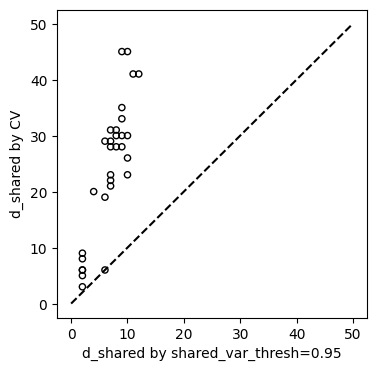

In [19]:
## Figure S1.
if RUN_CV:
    thres_component = []
    cv_component = []

    all_results = {}
    for i in range(len(df_singles)):
        # Check the d_shared obtained by two different methods
        s = df_singles.iloc[i].session_class
        fa_thres = fa.fa_fit(s.Y_norm, shared_var_thresh=0.95, max_iter=int(100))
        fa_cv = fa.fa_fit(s.Y_norm, cv_components=np.arange(s.Y_norm.shape[1]), max_iter=int(100))
        thres_component.append(fa_thres['d_shared'])
        cv_component.append(fa_cv['d_shared'])
        all_results[s.session_key] = {
            'fa_thres': fa_thres,
            'fa_cv': fa_cv
        }


    model_dir = os.path.join('models')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    joblib.dump(all_results, os.path.join(model_dir, 'fa_cv_vs_95.pkl'))

    plt.figure(figsize=(4,4))
    plt.scatter(thres_component, cv_component, s=20, ec='k', fc='none')
    plt.plot([0,50],[0,50], c='k', ls='--')
    plt.xlabel('d_shared by shared_var_thresh=0.95')
    plt.ylabel('d_shared by CV')

    save_plot_dir = os.path.join('plots', 'general_plots')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if SAVEFIG:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'd_shared_cv_vs_95.' + ext))
    plt.show()

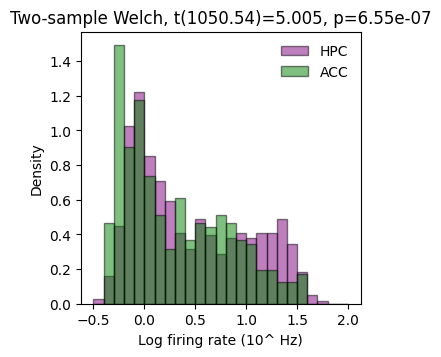

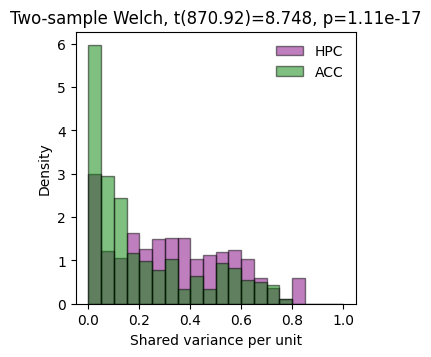

In [20]:
## Figure S2. Panel A and B.

hpc, acc = [], []
for i in range(len(df_singles)):
    s = df_singles.iloc[i].session_class
    hpc.extend(s.spikes_mu[s.hpc_ix])
    acc.extend(s.spikes_mu[s.acc_ix])

res = pg.ttest(hpc, acc, paired=False)
stats = res.iloc[0]['T']
pval = res.iloc[0]['p-val']
dof = res.iloc[0]['dof']
hpc = np.log10(hpc)
acc = np.log10(acc)

plt.figure(figsize=(4,4))
plt.hist(hpc, bins=np.linspace(-0.5,2,26), color=AREA_CLR['HPC'], alpha=0.5, edgecolor='k', density=True, label='HPC')
plt.hist(acc, bins=np.linspace(-0.5,2,26), color=AREA_CLR['ACC'], alpha=0.5, edgecolor='k', density=True, label='ACC')
plt.title(f'Two-sample Welch, t({dof:.2f})={stats:.3f}, p={pval:.2e}')
plt.xlabel('Log firing rate (10^ Hz)')
plt.ylabel('Density')
plt.subplots_adjust(hspace=0.1,left=0.2,right=0.9,bottom=0.2)
plt.legend(frameon=False)

save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'mean_firing_rate.' + ext))
plt.show()

hpc, acc = [], []
for i in range(len(df_singles)):
    s = df_singles.iloc[i].session_class
    hpc.extend(s.FA.shared_var_per_unit[s.hpc_ix])
    acc.extend(s.FA.shared_var_per_unit[s.acc_ix])


res = pg.ttest(hpc,acc, paired=False)
stats = res.iloc[0]['T']
pval = res.iloc[0]['p-val']
dof = res.iloc[0]['dof']

plt.figure(figsize=(4,4))
plt.hist(hpc, bins=np.linspace(0,1,21), color=AREA_CLR['HPC'], alpha=0.5, edgecolor='k', density=True, label='HPC')
plt.hist(acc, bins=np.linspace(0,1,21), color=AREA_CLR['ACC'], alpha=0.5, edgecolor='k', density=True, label='ACC')
plt.title(f'Two-sample Welch, t({dof:.2f})={stats:.3f}, p={pval:.2e}')
plt.xlabel('Shared variance per unit')
plt.ylabel('Density')
plt.subplots_adjust(hspace=0.1,left=0.2,right=0.9,bottom=0.2)
plt.legend(frameon=False)

save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, 'shared_var_per_unit.' + ext))
plt.show()

Analyzing podcast task sessions...
Found 9 analyzable podcast sessions over 9 patients. Found spikes in 9 sessions.
Analyzing pursuit task sessions...
Found 13 analyzable pursuit sessions over 10 patients. Found spikes in 13 sessions.
Analyzing rotations task sessions...
Found 8 analyzable rotations sessions over 8 patients. Found spikes in 8 sessions.


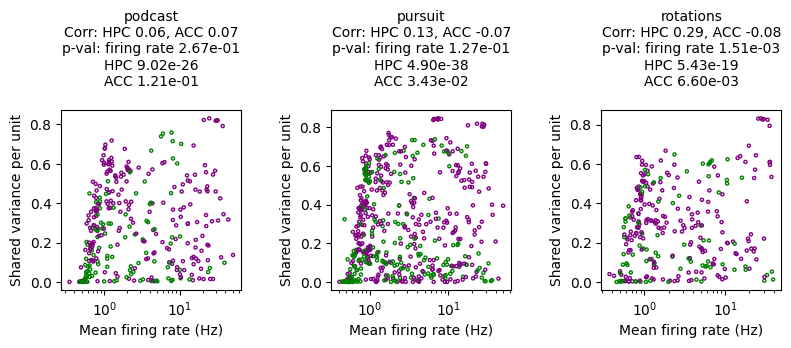

In [21]:
## Figure S2. Panel C, D, and E.
plt.figure(figsize=(9,3))
for j in range(len(TASK_NAMES)):
    dfs = get_single_task_df(df_singles, TASK_NAMES[j])
    svpu, mfr, region = [], [], []
    plt.subplot(1,3,j+1)
    for i in range(len(dfs)):
        s = dfs.iloc[i].session_class
        svpu.extend(s.FA.shared_var_per_unit)
        mfr.extend(s.spikes_mu)
        region.extend(s.hpc_ix)
    svpu = np.array(svpu)
    mfr = np.array(mfr)
    region = np.array(region)

    dd = pd.DataFrame({
        'shared_var_per_unit': svpu,
        'firing_rate': mfr, 
        'HPC': region.astype(int),
        'ACC': np.logical_not(region).astype(int)})
    result = sm.ols(formula='shared_var_per_unit ~ firing_rate + HPC + ACC', data=dd).fit()

    plt.scatter(mfr,svpu, s=5, ec=[AREA_CLR['HPC'] if i==True else AREA_CLR['ACC'] for i in region], fc='none')
    plt.xscale('log')
    plt.ylabel('Shared variance per unit')
    plt.xlabel('Mean firing rate (Hz)')
    hpc_corr = np.corrcoef(svpu[region], mfr[region])[0,1]
    acc_corr = np.corrcoef(svpu[~region], mfr[~region])[0,1]
    plt.title(f"""{TASK_NAMES[j]}
Corr: HPC {hpc_corr:.2f}, ACC {acc_corr:.2f}
p-val: firing rate {result.pvalues['firing_rate']:.2e}
HPC {result.pvalues['HPC']:.2e}
ACC {result.pvalues['ACC']:.2e}
""", fontsize=10)
plt.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.7, bottom=0.1)
save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'shared_var_per_unit_firing_rate.' + ext))
plt.show()

Analyzing podcast task sessions...
Found 7 analyzable podcast sessions over 7 patients. Found spikes in 7 sessions.
Analyzing pursuit task sessions...
Found 11 analyzable pursuit sessions over 8 patients. Found spikes in 11 sessions.
Analyzing rotations task sessions...
Found 6 analyzable rotations sessions over 6 patients. Found spikes in 6 sessions.


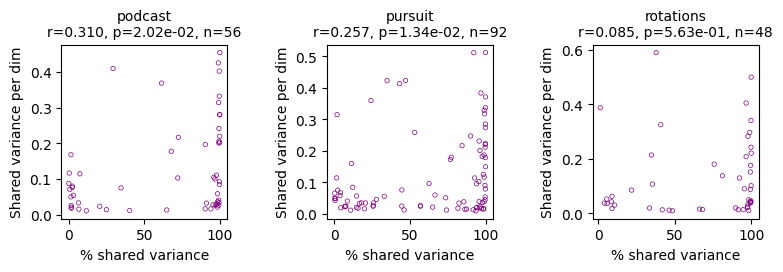

In [22]:
## Figure S3.
plt.figure(figsize=(9,3))

for j in range(len(TASK_NAMES)):
    dfs = get_single_task_df(df_singles[(df_singles['Patient']!='YEY')&(df_singles['Patient']!='YEZ')],
                             TASK_NAMES[j])
    plt.subplot(1,3,j+1)
    hpc_power, svpd = [], []
    for i in range(len(dfs)):
        s = dfs.iloc[i].session_class
        [_,S,_] = np.linalg.svd(s.FA.first_d_components) # Have to use pre-orthonorm otherwise S would all be 1
        svpd.extend(S**2 / np.sum(S**2))
        total_var_per_unit_per_dim = (s.FA.subspace)**2 # (d, N)
        hpc_power.extend(total_var_per_unit_per_dim[:, s.hpc_ix].sum(axis=1) * 100)
    r, pval = scipy.stats.pearsonr(np.array(hpc_power), np.array(svpd))
    
    plt.scatter(hpc_power, svpd, fc='none', ec=AREA_CLR['HPC'], s=10, lw=0.5)
    plt.ylabel('Shared variance per dim')
    plt.xlabel('% shared variance')
    plt.title(f'{TASK_NAMES[j]}\nr={r:.3f}, p={pval:.2e}, n={len(svpd)}',fontsize=10)
    plt.subplots_adjust(wspace=0.6, bottom=0.3)
save_plot_dir = os.path.join('plots', 'regional_difference')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'hpc_sv_and_svpd.' + ext))
plt.show()

Analyzing podcast task sessions...
Found 7 analyzable podcast sessions over 7 patients. Found spikes in 7 sessions.
0 out of 7 sessions in podcast
1 out of 7 sessions in podcast
2 out of 7 sessions in podcast
3 out of 7 sessions in podcast
4 out of 7 sessions in podcast
5 out of 7 sessions in podcast
6 out of 7 sessions in podcast


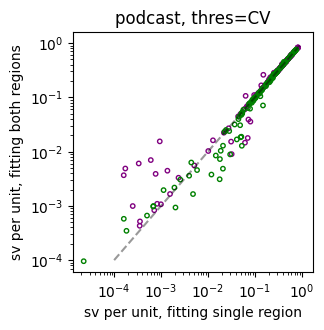

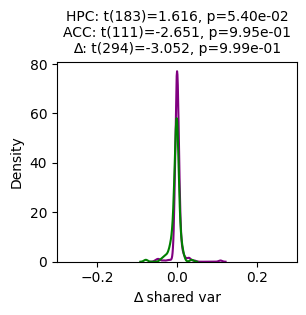

Analyzing pursuit task sessions...
Found 11 analyzable pursuit sessions over 8 patients. Found spikes in 11 sessions.
0 out of 11 sessions in pursuit
1 out of 11 sessions in pursuit
2 out of 11 sessions in pursuit
3 out of 11 sessions in pursuit
4 out of 11 sessions in pursuit
5 out of 11 sessions in pursuit
6 out of 11 sessions in pursuit
7 out of 11 sessions in pursuit
8 out of 11 sessions in pursuit
9 out of 11 sessions in pursuit
10 out of 11 sessions in pursuit


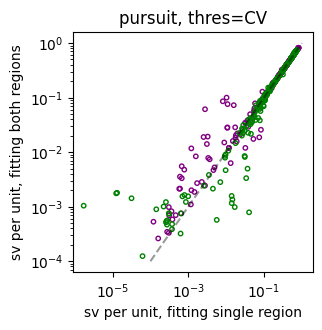

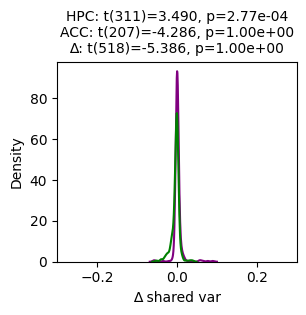

Analyzing rotations task sessions...
Found 6 analyzable rotations sessions over 6 patients. Found spikes in 6 sessions.
0 out of 6 sessions in rotations
1 out of 6 sessions in rotations
2 out of 6 sessions in rotations
3 out of 6 sessions in rotations
4 out of 6 sessions in rotations
5 out of 6 sessions in rotations


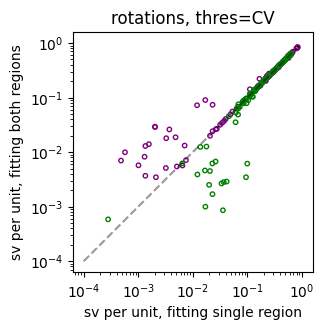

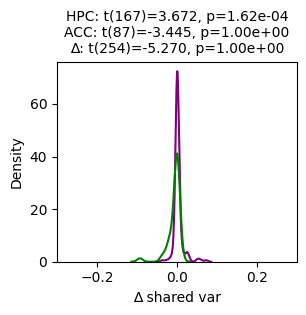

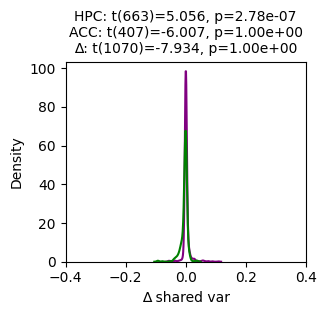

In [23]:
## Figure S4. 
dfs = df_singles[(df_singles.Patient!='YEY')&(df_singles.Patient!='YEZ')]
hpc_diffs, acc_diffs = [], []
for j in range(len(TASK_NAMES)):
    df = get_single_task_df(dfs, TASK_NAMES[j])

    hpc_svpu, acc_svpu, hpc_svpu_add, acc_svpu_add = [], [] ,[] ,[]
    hpc_diff, acc_diff = [], []

    for i in range(len(df)):
        print(f'{i} out of {len(df)} sessions in {TASK_NAMES[j]}')
        s = df.iloc[i].session_class
        Y = s.Y_norm

        # Fit FA for each region and both regions
        FA_hpc = io.FactorAnalysisResult(fa.fa_fit(Y[:, s.hpc_ix]))
        FA_acc = io.FactorAnalysisResult(fa.fa_fit(Y[:, s.acc_ix]))
        FA_all = io.FactorAnalysisResult(fa.fa_fit(Y))

        # Store shared var per unit
        hpc_svpu.extend(FA_hpc.shared_var_per_unit) # HPC's sv per unit (svpu) when fitting HPC only
        acc_svpu.extend(FA_acc.shared_var_per_unit) # ACC's svpu when fitting ACC only
        hpc_svpu_add.extend(FA_all.shared_var_per_unit[s.hpc_ix]) # HPC's svpu when fitting both regions
        acc_svpu_add.extend(FA_all.shared_var_per_unit[s.acc_ix]) # ACC's svpu when fitting both regions

        # Also store the difference
        hpc_diff.extend(FA_all.shared_var_per_unit[s.hpc_ix] - FA_hpc.shared_var_per_unit)
        acc_diff.extend(FA_all.shared_var_per_unit[s.acc_ix] - FA_acc.shared_var_per_unit)

    hpc_diffs.extend(hpc_diff)
    acc_diffs.extend(acc_diff)
    
    plt.figure(figsize=(4,4))
    plt.scatter(hpc_svpu, hpc_svpu_add, s=10, ec=AREA_CLR['HPC'], fc='none')
    plt.scatter(acc_svpu, acc_svpu_add, s=10, ec=AREA_CLR['ACC'], fc='none')
    plt.xlabel('sv per unit, fitting single region')
    plt.ylabel('sv per unit, fitting both regions')
    plt.plot([1e-4,1],[1e-4,1], c='k', ls='--', alpha=0.4)
    plt.title(f'{TASK_NAMES[j]}, thres=CV')
    plt.xscale('log')
    plt.yscale('log')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)

    save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if SAVEFIG:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'{TASK_NAMES[j]}_95.' + ext))
    plt.show()

    stats, pval = scipy.stats.ttest_1samp(acc_diff, 0, alternative='greater')
    acc_info = f'ACC: t({len(acc_diff)-1})={stats:.3f}, p={pval:.2e}'
    stats, pval = scipy.stats.ttest_1samp(hpc_diff, 0, alternative='greater')
    hpc_info = f'HPC: t({len(hpc_diff)-1})={stats:.3f}, p={pval:.2e}'
    stats, pval = scipy.stats.ttest_ind(acc_diff, hpc_diff, alternative='greater')
    diff_info = f'∆: t({len(hpc_diff)+len(acc_diff)-2})={stats:.3f}, p={pval:.2e}'
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    sns.kdeplot(hpc_diff, ax=ax,color=AREA_CLR['HPC'])
    sns.kdeplot(acc_diff, ax=ax,color=AREA_CLR['ACC'])
    ax.set_xlim([-0.3,0.3])

    ax.set_title(f'{hpc_info}\n{acc_info}\n{diff_info}', fontsize=10)
    ax.set_xlabel('∆ shared var')
    ax.set_ylabel('Density')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.2)

    save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
    if not os.path.exists(save_plot_dir):
        os.makedirs(save_plot_dir)
    if SAVEFIG:
        for ext in ['png','svg']:
            plt.savefig(os.path.join(save_plot_dir, f'{TASK_NAMES[j]}_diff_95.' + ext))
    plt.show()

stats, pval = scipy.stats.ttest_1samp(acc_diffs, 0, alternative='greater')
acc_info = f'ACC: t({len(acc_diffs)-1})={stats:.3f}, p={pval:.2e}'
stats, pval = scipy.stats.ttest_1samp(hpc_diffs, 0, alternative='greater')
hpc_info = f'HPC: t({len(hpc_diffs)-1})={stats:.3f}, p={pval:.2e}'
stats, pval = scipy.stats.ttest_ind(acc_diffs, hpc_diffs, alternative='greater')
diff_info = f'∆: t({len(hpc_diffs)+len(acc_diffs)-2})={stats:.3f}, p={pval:.2e}'
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.kdeplot(hpc_diffs, ax=ax,color=AREA_CLR['HPC'])
sns.kdeplot(acc_diffs, ax=ax,color=AREA_CLR['ACC'])

ax.set_xlim([-0.4,0.4])
ax.set_title(f'{hpc_info}\n{acc_info}\n{diff_info}', fontsize=10)
ax.set_xlabel('∆ shared var')
ax.set_ylabel('Density')
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.2)

save_plot_dir = os.path.join('plots', 'regional_difference', 'one_vs_both_regions')
if not os.path.exists(save_plot_dir):
    os.makedirs(save_plot_dir)
if SAVEFIG:
    for ext in ['png','svg']:
        plt.savefig(os.path.join(save_plot_dir, f'diff_95_ALL.' + ext))
plt.show()

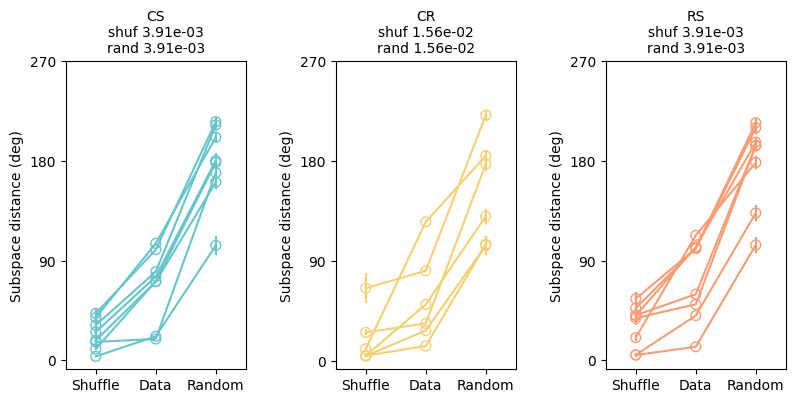

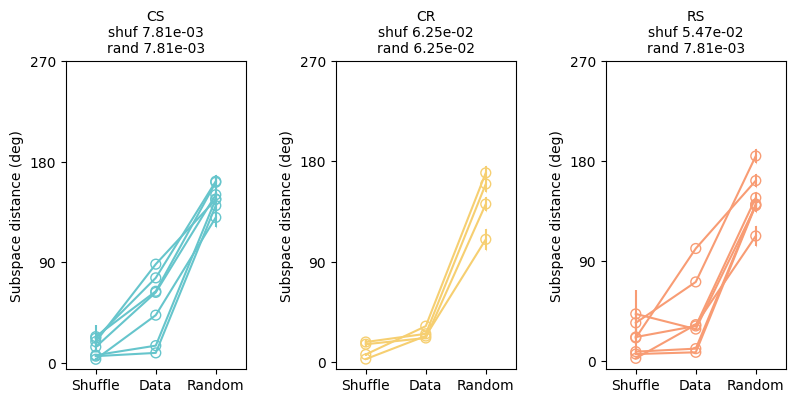

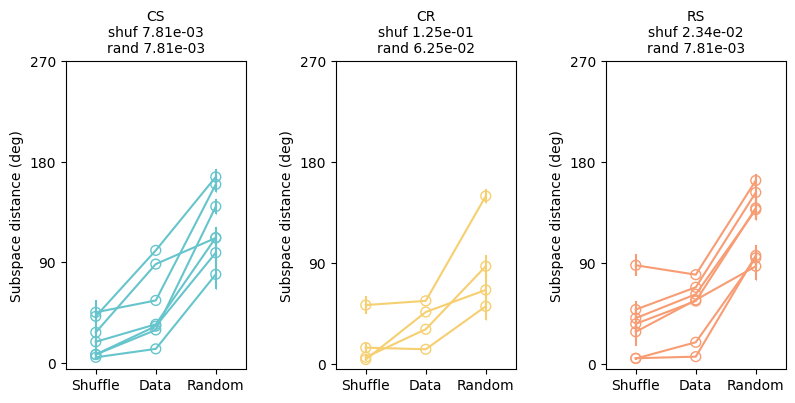

In [24]:
## Figure S6.
df_pairs = get_paired_df(df_singles)
df_pairs_both = add_distance_metrics(df_pairs, mode="both", niters_rand=100, niters_shuf=30)

df_pairs = df_pairs[(df_pairs.subj!='Y') & (df_pairs.subj!='Z')]
if not hasattr(df_pairs.iloc[0].task_1, "FA_acc"):
    for _, row in df_pairs.iterrows():
        s1, s2 = row.task_1, row.task_2
        s1.FA_acc = s1.find_subspace(s1.Y[:, s1.acc_ix], verbose=False)
        s1.FA_hpc = s1.find_subspace(s1.Y[:, s1.hpc_ix], verbose=False)
        s2.FA_acc = s2.find_subspace(s2.Y[:, s2.acc_ix], verbose=False)
        s2.FA_hpc = s2.find_subspace(s2.Y[:, s2.hpc_ix], verbose=False)

df_pairs_hpc = add_distance_metrics(df_pairs, mode="hpc", niters_rand=100, niters_shuf=30)
df_pairs_acc = add_distance_metrics(df_pairs, mode="acc", niters_rand=30, niters_shuf=30)

plot_geodesic_distance(df_pairs_both, "both", savefig=SAVEFIG)
plot_geodesic_distance(df_pairs_hpc, "hpc", savefig=SAVEFIG)
plot_geodesic_distance(df_pairs_acc, "acc", savefig=SAVEFIG)